In [1]:
import pandas as pd
import math
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns

#load the statistical libraries
from statsmodels.stats import diagnostic
from scipy import stats


In [2]:
df = pd.read_csv("transaction_dataset.csv")

In [3]:
df.columns

Index(['Unnamed: 0', 'Index', 'Address', 'FLAG', 'Avg min between sent tnx',
       'Avg min between received tnx',
       'Time Diff between first and last (Mins)', 'Sent tnx', 'Received Tnx',
       'Number of Created Contracts', 'Unique Received From Addresses',
       'Unique Sent To Addresses', 'min value received', 'max value received ',
       'avg val received', 'min val sent', 'max val sent', 'avg val sent',
       'min value sent to contract', 'max val sent to contract',
       'avg value sent to contract',
       'total transactions (including tnx to create contract',
       'total Ether sent', 'total ether received',
       'total ether sent contracts', 'total ether balance',
       ' Total ERC20 tnxs', ' ERC20 total Ether received',
       ' ERC20 total ether sent', ' ERC20 total Ether sent contract',
       ' ERC20 uniq sent addr', ' ERC20 uniq rec addr',
       ' ERC20 uniq sent addr.1', ' ERC20 uniq rec contract addr',
       ' ERC20 avg time between sent tnx', ' ERC20 

In [4]:
df.columns.shape[0] - 4

47

In [5]:
#Rename columns for easier access
df.columns = df.columns.str.strip().str.replace(' ','_').str.lower()

#Remove weird stuff 
df = df.drop(columns=['unnamed:_0'])

#Remove duplicate accounts
print("Size = "+str(df.shape[0]))
df = df.drop_duplicates(subset=['address'])
print("Size without duplicates = "+str(df.shape[0]))

#Replace nan values by median 
df.fillna(df.median(numeric_only=True), inplace=True)

total = df.shape[0]
total_frauds = df["flag"].sum()
df.head()

Size = 9841
Size without duplicates = 9816


,index,address,flag,avg_min_between_sent_tnx,avg_min_between_received_tnx,time_diff_between_first_and_last_(mins),sent_tnx,received_tnx,number_of_created_contracts,unique_received_from_addresses,...,erc20_min_val_sent,erc20_max_val_sent,erc20_avg_val_sent,erc20_min_val_sent_contract,erc20_max_val_sent_contract,erc20_avg_val_sent_contract,erc20_uniq_sent_token_name,erc20_uniq_rec_token_name,erc20_most_sent_token_type,erc20_most_rec_token_type
0,1,0x00009277775ac7d0d59eaad8fee3d10ac6c805e8,0,844.26,1093.71,704785.63,721,89,0,40,...,0.000000,1.683100e+07,271779.920000,0.0,0.0,0.0,39.0,57.0,Cofoundit,Numeraire
1,2,0x0002b44ddb1476db43c868bd494422ee4c136fed,0,12709.07,2958.44,1218216.73,94,8,0,5,...,2.260809,2.260809e+00,2.260809,0.0,0.0,0.0,1.0,7.0,Livepeer Token,Livepeer Token
2,3,0x0002bda54cb772d040f779e88eb453cac0daa244,0,246194.54,2434.02,516729.30,2,10,0,10,...,0.000000,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,8.0,None,XENON
3,4,0x00038e6ba2fd5c09aedb96697c8d7b8fa6632e5e,0,10219.60,15785.09,397555.90,25,9,0,7,...,100.000000,9.029231e+03,3804.076893,0.0,0.0,0.0,1.0,11.0,Raiden,XENON
4,5,0x00062d1dd1afb6fb02540ddad9cdebfe568e0d89,0,36.61,10707.77,382472.42,4598,20,1,7,...,0.000000,4.500000e+04,13726.659220,0.0,0.0,0.0,6.0,27.0,StatusNetwork,EOS


### fraud distribution of the dataset

#Accounts = 9816
#Flagged accounts = 2179
Percentage of flagged accounts = 22.2 %


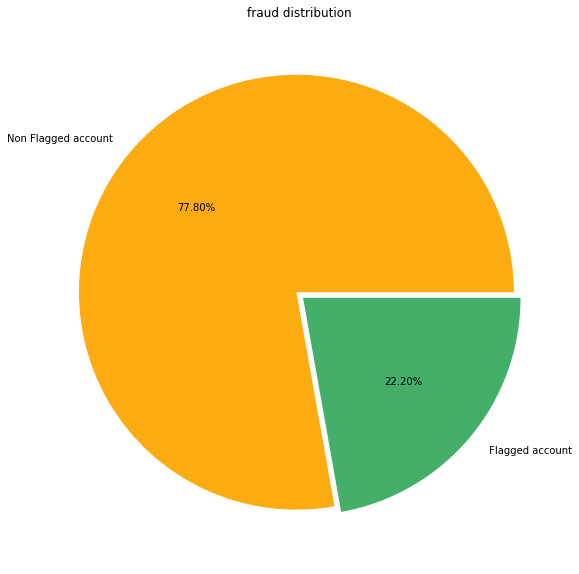

<Figure size 432x288 with 0 Axes>

In [6]:
print("#Accounts = " + str(total) + "\n" "#Flagged accounts = " + str(total_frauds))
print("Percentage of flagged accounts = " + str(round(total_frauds / total, 4) * 100) + " %")
 
pie, ax = plt.subplots(figsize=[15,10])
labels = ['Non Flagged account', ' Flagged account']
colors = ['#FCAB10', '#44AF69']
plt.pie(x = df['flag'].value_counts(), labels = labels, colors = colors, explode=[0.02] * 2,  autopct='%.2f%%')
plt.title('fraud distribution')
plt.show()
plt.savefig("fraud_distribution_pie.png")

### facts about average transaction values, amounts, connections etc

In [7]:
# We might not want our model to be limited to token names. 
# I suggest we drop the columns -> 
token_cols = ['erc20_most_sent_token_type','erc20_most_rec_token_type']
df[token_cols].head()
df = df.drop(columns=token_cols)

###### IDEA (Alex)
# If our model uses token names to make its decision, new accounts with different tokens 
# will be incorrectly classified according to our training. 

# This is of course open to discussion 
#We can code  a f that classifies the token names as numerals and then we can reserve one numeral for all unknown token names. 

In [8]:
# Observing the columns with variances = 0
zero_var_cols = []
for col in df.columns[2:] :
    if np.var(df[col]) == 0 :
        print(col)
        zero_var_cols.append(col)
#These columns shouldn't be kept as they do not contribute to our classification problem
display(df[zero_var_cols].head(10))
df = df.drop(columns=zero_var_cols)

erc20_avg_time_between_sent_tnx
erc20_avg_time_between_rec_tnx
erc20_avg_time_between_rec_2_tnx
erc20_avg_time_between_contract_tnx
erc20_min_val_sent_contract
erc20_max_val_sent_contract
erc20_avg_val_sent_contract


,erc20_avg_time_between_sent_tnx,erc20_avg_time_between_rec_tnx,erc20_avg_time_between_rec_2_tnx,erc20_avg_time_between_contract_tnx,erc20_min_val_sent_contract,erc20_max_val_sent_contract,erc20_avg_val_sent_contract
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
print(df.columns)
display(df.head())

Index(['index', 'address', 'flag', 'avg_min_between_sent_tnx',
       'avg_min_between_received_tnx',
       'time_diff_between_first_and_last_(mins)', 'sent_tnx', 'received_tnx',
       'number_of_created_contracts', 'unique_received_from_addresses',
       'unique_sent_to_addresses', 'min_value_received', 'max_value_received',
       'avg_val_received', 'min_val_sent', 'max_val_sent', 'avg_val_sent',
       'min_value_sent_to_contract', 'max_val_sent_to_contract',
       'avg_value_sent_to_contract',
       'total_transactions_(including_tnx_to_create_contract',
       'total_ether_sent', 'total_ether_received',
       'total_ether_sent_contracts', 'total_ether_balance', 'total_erc20_tnxs',
       'erc20_total_ether_received', 'erc20_total_ether_sent',
       'erc20_total_ether_sent_contract', 'erc20_uniq_sent_addr',
       'erc20_uniq_rec_addr', 'erc20_uniq_sent_addr.1',
       'erc20_uniq_rec_contract_addr', 'erc20_min_val_rec',
       'erc20_max_val_rec', 'erc20_avg_val_rec', 'erc

,index,address,flag,avg_min_between_sent_tnx,avg_min_between_received_tnx,time_diff_between_first_and_last_(mins),sent_tnx,received_tnx,number_of_created_contracts,unique_received_from_addresses,...,erc20_uniq_sent_addr.1,erc20_uniq_rec_contract_addr,erc20_min_val_rec,erc20_max_val_rec,erc20_avg_val_rec,erc20_min_val_sent,erc20_max_val_sent,erc20_avg_val_sent,erc20_uniq_sent_token_name,erc20_uniq_rec_token_name
0,1,0x00009277775ac7d0d59eaad8fee3d10ac6c805e8,0,844.26,1093.71,704785.63,721,89,0,40,...,0.0,58.0,0.0,1.500000e+07,265586.147600,0.000000,1.683100e+07,271779.920000,39.0,57.0
1,2,0x0002b44ddb1476db43c868bd494422ee4c136fed,0,12709.07,2958.44,1218216.73,94,8,0,5,...,0.0,7.0,0.0,3.650000e+02,57.632615,2.260809,2.260809e+00,2.260809,1.0,7.0
2,3,0x0002bda54cb772d040f779e88eb453cac0daa244,0,246194.54,2434.02,516729.30,2,10,0,10,...,0.0,8.0,0.0,4.428198e+02,65.189009,0.000000,0.000000e+00,0.000000,0.0,8.0
3,4,0x00038e6ba2fd5c09aedb96697c8d7b8fa6632e5e,0,10219.60,15785.09,397555.90,25,9,0,7,...,0.0,11.0,0.0,1.141223e+04,1555.550174,100.000000,9.029231e+03,3804.076893,1.0,11.0
4,5,0x00062d1dd1afb6fb02540ddad9cdebfe568e0d89,0,36.61,10707.77,382472.42,4598,20,1,7,...,0.0,27.0,0.0,9.000000e+04,4934.232147,0.000000,4.500000e+04,13726.659220,6.0,27.0


In [10]:
df['flag'].value_counts()
# Observing data distribution for the remaining columns
small_distr_col = []
for col in df.columns[3:] :
    if len(df[col].value_counts()) < 10:
        print(df[col].value_counts())
        print()
        small_distr_col.append(col)
#As we can see, all these columns are useless since almost no rows have different values. 
df = df.drop(columns=small_distr_col)

0.00    9814
0.02       1
0.01       1
Name: min_value_sent_to_contract, dtype: int64

0.000000    9813
0.020000       1
0.010000       1
0.046029       1
Name: max_val_sent_to_contract, dtype: int64

0.000000    9813
0.020000       1
0.010000       1
0.023014       1
Name: avg_value_sent_to_contract, dtype: int64

0.000000    9813
0.020000       1
0.010000       1
0.046029       1
Name: total_ether_sent_contracts, dtype: int64

0.0    9788
1.0      26
3.0       1
2.0       1
Name: erc20_uniq_sent_addr.1, dtype: int64



In [11]:
df.columns

Index(['index', 'address', 'flag', 'avg_min_between_sent_tnx',
       'avg_min_between_received_tnx',
       'time_diff_between_first_and_last_(mins)', 'sent_tnx', 'received_tnx',
       'number_of_created_contracts', 'unique_received_from_addresses',
       'unique_sent_to_addresses', 'min_value_received', 'max_value_received',
       'avg_val_received', 'min_val_sent', 'max_val_sent', 'avg_val_sent',
       'total_transactions_(including_tnx_to_create_contract',
       'total_ether_sent', 'total_ether_received', 'total_ether_balance',
       'total_erc20_tnxs', 'erc20_total_ether_received',
       'erc20_total_ether_sent', 'erc20_total_ether_sent_contract',
       'erc20_uniq_sent_addr', 'erc20_uniq_rec_addr',
       'erc20_uniq_rec_contract_addr', 'erc20_min_val_rec',
       'erc20_max_val_rec', 'erc20_avg_val_rec', 'erc20_min_val_sent',
       'erc20_max_val_sent', 'erc20_avg_val_sent',
       'erc20_uniq_sent_token_name', 'erc20_uniq_rec_token_name'],
      dtype='object')

In [12]:
df.to_csv("preprocessed_data.csv")

### 1) visualising data 

<AxesSubplot:>

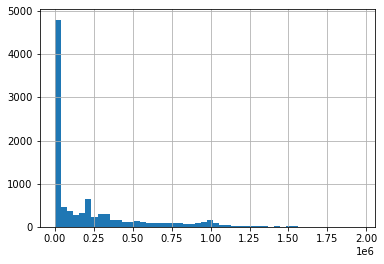

In [13]:
df['time_diff_between_first_and_last_(mins)'].hist(bins=50)

# VISUALISING DATA


 The “relationships” can be tested in different statistical ways, depending on the goal of the research.  The three most common meanings of “relationship” between/among variables are:
1.      Strength, or association, between variables = e.g., Pearson & Spearman rho correlations
2.      Statistical differences on a continuous variable by group(s) = e.g., t-test and ANOVA
3.      Statistical contribution/prediction on a variable from another(s) = regression.

## linear regression


With this, we want to identify if : 
   1. The problem can be solved with linear regression
   2. Which of the parameters are the most relevant for the prediction 


In [14]:
from sklearn.linear_model import LinearRegression

## Pearson correlation 

The Pearson correlation coefficient [1] measures the linear relationship between two datasets. Like other correlation coefficients, this one varies between -1 and +1 with 0 implying no correlation. Correlations of -1 or +1 imply an exact linear relationship. Positive correlations imply that as x increases, so does y. Negative correlations imply that as x increases, y decreases.

output is (statistic, p-value) 

In [15]:
#Compute the pearson coefficient between columns to determine if columns are statistically related
def pearson_computations(): 
    total = 0
    countp = 0
    count = 0
    columns = df.columns
    print("printing the column pairs that have both sufficiently low p values and a pearson test with correlation bigger",
         "than 0.5")
    for pos, col1 in enumerate(columns):
        for col2 in columns[pos:]:
            if col1 != col2:
                if isinstance(df[col1][0], np.float64) and isinstance(df[col2][0], np.float64):
                    total+=1
                    statistic, pValue = stats.pearsonr(df[col1],df[col2])
                    if abs(statistic) > 0.5:
                        count+=1
                        #skip the values that have a small p due to the
                        # effects of Non-Normality on the Distribution of the Sample Product-Moment Correlation Coefficient
                        if pValue < 0.05:
                            countp+=1
                            print(col1, " and ", col2)
                                
    print("There is a total", total, "pearson tests that have been run on the pair of columns")
    print("Only", count, "of these values have statistical relations from the pearson test, and among these", countp,
          "also having sufficiently small p values")


In [16]:
pearson_computations()

printing the column pairs that have both sufficiently low p values and a pearson test with correlation bigger than 0.5
max_value_received  and  avg_val_received
min_val_sent  and  avg_val_sent
max_val_sent  and  total_ether_balance
total_ether_sent  and  total_ether_received
total_erc20_tnxs  and  erc20_uniq_sent_addr
total_erc20_tnxs  and  erc20_uniq_rec_addr
erc20_total_ether_received  and  erc20_max_val_rec
erc20_total_ether_received  and  erc20_avg_val_rec
erc20_total_ether_sent  and  erc20_min_val_sent
erc20_total_ether_sent  and  erc20_max_val_sent
erc20_total_ether_sent  and  erc20_avg_val_sent
erc20_uniq_sent_addr  and  erc20_uniq_rec_addr
erc20_uniq_rec_contract_addr  and  erc20_uniq_sent_token_name
erc20_uniq_rec_contract_addr  and  erc20_uniq_rec_token_name
erc20_max_val_rec  and  erc20_avg_val_rec
erc20_min_val_sent  and  erc20_max_val_sent
erc20_min_val_sent  and  erc20_avg_val_sent
erc20_max_val_sent  and  erc20_avg_val_sent
erc20_uniq_sent_token_name  and  erc20_uniq_rec

## ANOVA

In [17]:
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import f_classif
from matplotlib import pyplot


In [18]:
# feature selection
def select_features(X_train, y_train, X_test):
    # configure to select all features
    fs = SelectKBest(score_func=f_classif, k='all')
    # learn relationship from training data
    fs.fit(X_train, y_train)
    # transform train input data
    X_train_fs = fs.transform(X_train)
    # transform test input data
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

In [19]:
df.columns = [x.lower() for x in df.columns]
df.fillna(df.median(numeric_only=True), inplace=True)

y = df['flag']
df = df.drop("flag", axis = 1)
X = df

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

'''
X_train = X_train.drop("index", axis =1) 
X_train = X_train.drop("address", axis =1) 
X_train = X_train.drop(" erc20 most sent token type", axis =1) 
X_train = X_train.drop(" erc20_most_rec_token_type", axis =1) 


X_test = X_test.drop("index", axis =1) 
X_test = X_test.drop("address", axis =1) 
X_test = X_test.drop(" erc20 most sent token type", axis =1) 
X_test = X_test.drop(" erc20_most_rec_token_type", axis =1) 
'''


'\nX_train = X_train.drop("index", axis =1) \nX_train = X_train.drop("address", axis =1) \nX_train = X_train.drop(" erc20 most sent token type", axis =1) \nX_train = X_train.drop(" erc20_most_rec_token_type", axis =1) \n\n\nX_test = X_test.drop("index", axis =1) \nX_test = X_test.drop("address", axis =1) \nX_test = X_test.drop(" erc20 most sent token type", axis =1) \nX_test = X_test.drop(" erc20_most_rec_token_type", axis =1) \n'

In [20]:
X_train = X_train.drop("index", axis =1) 
X_train = X_train.drop("address", axis =1) 
X_test = X_test.drop("index", axis =1) 
X_test = X_test.drop("address", axis =1) 


In [21]:
X_train

,avg_min_between_sent_tnx,avg_min_between_received_tnx,time_diff_between_first_and_last_(mins),sent_tnx,received_tnx,number_of_created_contracts,unique_received_from_addresses,unique_sent_to_addresses,min_value_received,max_value_received,...,erc20_uniq_rec_addr,erc20_uniq_rec_contract_addr,erc20_min_val_rec,erc20_max_val_rec,erc20_avg_val_rec,erc20_min_val_sent,erc20_max_val_sent,erc20_avg_val_sent,erc20_uniq_sent_token_name,erc20_uniq_rec_token_name
2608,26.29,0.00,78.88,3,2,0,2,3,23.344561,77.655439,...,0.0,0.0,0.0,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.0,0.0
6959,160.77,0.84,323.22,2,2,0,2,2,26.207330,74.792670,...,0.0,0.0,0.0,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.0,0.0
376,59.44,2085.10,906247.85,408,423,0,1,1,0.010430,1.077652,...,2.0,2.0,0.0,1.000000e+02,50.000000,0.000000,0.000000e+00,0.000000,0.0,2.0
4048,6075.00,12437.12,496623.32,6,37,0,1,5,0.013797,0.500001,...,5.0,7.0,0.0,3.650000e+02,73.778409,0.000000,0.000000e+00,0.000000,0.0,7.0
3276,176900.38,1356.74,887215.38,5,2,0,1,5,199.995290,200.141410,...,14.0,18.0,0.0,8.002734e+03,594.234463,30.140816,3.014082e+01,30.140816,1.0,18.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2895,2.11,0.52,7.35,3,2,0,2,3,539.434317,1461.565683,...,0.0,0.0,0.0,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.0,0.0
7838,832.46,2929.85,78078.70,41,15,0,10,28,0.092240,16.855948,...,6.0,13.0,0.0,1.704864e+06,135735.336000,0.000000,2.070864e+06,222075.914300,11.0,13.0
905,167.62,0.01,335.28,2,3,0,3,2,2.467068,50.998992,...,0.0,0.0,0.0,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.0,0.0
5217,160.63,1.46,324.18,2,2,0,2,2,12.352366,88.647634,...,0.0,0.0,0.0,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.0,0.0


Feature 0: 4.043708
Feature 1: 82.201689
Feature 2: 506.060769
Feature 3: 41.146654
Feature 4: 41.923271
Feature 5: 1.237954
Feature 6: 5.383050
Feature 7: 15.377049
Feature 8: 1.310737
Feature 9: 2.340886
Feature 10: 0.794314
Feature 11: 0.295905
Feature 12: 2.840593
Feature 13: 15.592223
Feature 14: 68.959454
Feature 15: 1.657663
Feature 16: 2.305988
Feature 17: 0.059182
Feature 18: 7.578798
Feature 19: 0.294522
Feature 20: 3.402756
Feature 21: 0.301845
Feature 22: 5.033682
Feature 23: 5.572748
Feature 24: 20.086253
Feature 25: 0.305194
Feature 26: 0.281917
Feature 27: 0.185619
Feature 28: 3.528037
Feature 29: 3.442168
Feature 30: 3.465572
Feature 31: 4.032434
Feature 32: 19.943621


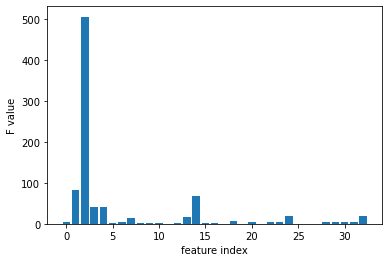

In [22]:
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)
# what are scores for the features
for i in range(len(fs.scores_)):
    print('Feature %d: %f' % (i, fs.scores_[i]))
# plot the scores
pyplot.bar([i for i in range(len(fs.scores_))], fs.scores_)
pyplot.xlabel("feature index")
pyplot.ylabel("F value")
pyplot.show()

In [23]:


columns = pd.DataFrame(X_train.columns)
scores = pd.DataFrame(fs.scores_)
feature_scores= pd.concat([columns, scores], axis = 1)
feature_scores.columns = ["feature", "scores"]
feature_scores.sort_values(by="scores", ascending=False, inplace=True)


In [24]:
feature_scores['scores']

2     506.060769
1      82.201689
14     68.959454
4      41.923271
3      41.146654
24     20.086253
32     19.943621
13     15.592223
7      15.377049
18      7.578798
23      5.572748
6       5.383050
22      5.033682
0       4.043708
31      4.032434
28      3.528037
30      3.465572
29      3.442168
20      3.402756
12      2.840593
9       2.340886
16      2.305988
15      1.657663
8       1.310737
5       1.237954
10      0.794314
25      0.305194
21      0.301845
11      0.295905
19      0.294522
26      0.281917
27      0.185619
17      0.059182
Name: scores, dtype: float64

In [25]:
maxval_feature_index = np.array([])
for i, s in zip(range(33), fs.scores_):
    print(i)
    print(s)
    if s > 5:
        maxval_feature_index = np.append(maxval_feature_index,i)


0
4.0437083969495955
1
82.20168898772154
2
506.06076928200144
3
41.146654019248786
4
41.92327054829494
5
1.2379537653398085
6
5.383050362915237
7
15.377049464059358
8
1.3107374757174355
9
2.3408859449843686
10
0.7943142035368247
11
0.2959053529565459
12
2.840592918060544
13
15.592223303719859
14
68.9594536112946
15
1.6576633603270803
16
2.3059875592929195
17
0.05918159160002984
18
7.578798472654413
19
0.294522164898115
20
3.402756432409441
21
0.301844683841775
22
5.033681976206839
23
5.572748061967617
24
20.086253016272675
25
0.3051944674356606
26
0.2819168132953651
27
0.18561851101101604
28
3.528037207844378
29
3.442167509945185
30
3.4655721181476915
31
4.032433936967375
32
19.94362072860051


In [26]:
for i in (maxval_feature_index):
    print(X_train.columns[i])

avg_min_between_received_tnx
time_diff_between_first_and_last_(mins)
sent_tnx
received_tnx
unique_received_from_addresses
unique_sent_to_addresses
avg_val_sent
total_transactions_(including_tnx_to_create_contract
total_erc20_tnxs
erc20_uniq_sent_addr
erc20_uniq_rec_addr
erc20_uniq_rec_contract_addr
erc20_uniq_rec_token_name


C:\Users\tziya\AppData\Local\Temp/ipykernel_21096/3780937538.py:2: FutureWarning: Indexing with a float is deprecated, and will raise an IndexError in pandas 2.0. You can manually convert to an integer key instead.
  print(X_train.columns[i])


<AxesSubplot:title={'center':'ANOVA Results'}, xlabel='feature', ylabel='F value'>

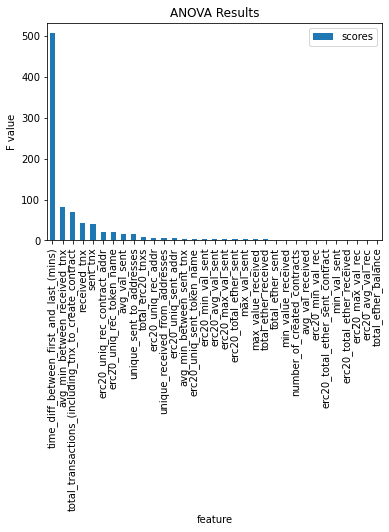

In [27]:


columns = pd.DataFrame(X_train.columns)
scores = pd.DataFrame(fs.scores_)
feature_scores= pd.concat([columns, scores], axis = 1)
feature_scores.columns = ["feature", "scores"]
feature_scores.sort_values(by="scores", ascending=False, inplace=True)

feature_scores.plot(kind = 'bar', title = 'ANOVA Results', x = "feature", y = "scores",ylabel = 'F value')


### Distribution of Feature 1

Text(0.5, 1.0, 'Feature 1')

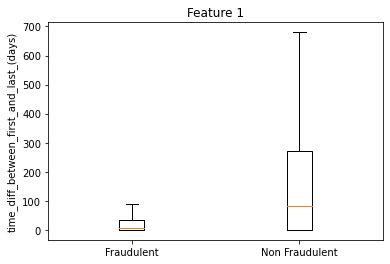

In [29]:

feature1 = pd.DataFrame(X_train['time_diff_between_first_and_last_(mins)'])
feature1_flag = pd.DataFrame(y_train)
feature_1_df = pd.concat([feature1, feature1_flag], axis = 1)

dataf11 = feature_1_df[feature_1_df['flag'] == 1]['time_diff_between_first_and_last_(mins)']/1440
dataf10 = feature_1_df[feature_1_df['flag'] == 0]['time_diff_between_first_and_last_(mins)']/1440

my_dict = {'Fraudulent': dataf11, 'Non Fraudulent': dataf10}

fig, ax = plt.subplots()
ax.boxplot(my_dict.values(),showfliers=False)

ax.set_xticklabels(my_dict.keys())
ax.set_ylabel("time_diff_between_first_and_last_(days)")
#plt.yscale("log")

ax.set_title("Feature 1")

### Distribution of Feature 2 

Text(0.5, 1.0, 'Feature2')

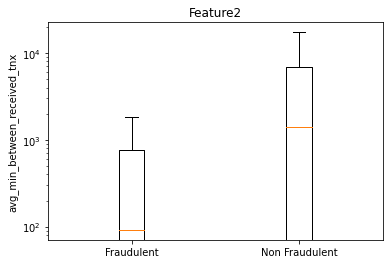

In [31]:
feature2 = pd.DataFrame(X_train['avg_min_between_received_tnx'])
feature2_flag = pd.DataFrame(y_train)
feature_2_df = pd.concat([feature2, feature2_flag], axis = 1)
feature_2_df.columns = ["avg_min_between_received_tnx", "flag"]

dataf21 = feature_2_df[feature_2_df['flag'] == 1]['avg_min_between_received_tnx']
dataf20 = feature_2_df[feature_2_df['flag'] == 0]['avg_min_between_received_tnx']

my_dict = {'Fraudulent': dataf21, 'Non Fraudulent': dataf20}

fig, ax = plt.subplots()
ax.boxplot(my_dict.values(),showfliers=False)

ax.set_xticklabels(my_dict.keys())
ax.set_ylabel("avg_min_between_received_tnx")
plt.yscale("log")

ax.set_title("Feature2")

### Distribution of Feature 3

Text(0.5, 1.0, 'Feature3')

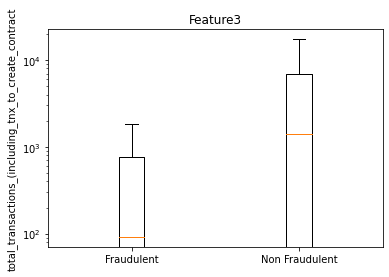

In [32]:

feature3 = pd.DataFrame(X_train['total_transactions_(including_tnx_to_create_contract'])
feature3_flag = pd.DataFrame(y_train)
feature_3_df = pd.concat([feature2, feature2_flag], axis = 1)
feature_3_df.columns = ["total_transactions_(including_tnx_to_create_contract", "flag"]


dataf31 = feature_3_df[feature_3_df['flag'] == 1]['total_transactions_(including_tnx_to_create_contract']
dataf30 = feature_3_df[feature_3_df['flag'] == 0]['total_transactions_(including_tnx_to_create_contract']

my_dict = {'Fraudulent': dataf31, 'Non Fraudulent': dataf30}

fig, ax = plt.subplots()
ax.boxplot(my_dict.values(),showfliers=False)

ax.set_xticklabels(my_dict.keys())
ax.set_ylabel("total_transactions_(including_tnx_to_create_contract")
plt.yscale("log")

ax.set_title("Feature3")

### Distribution of Feature 4

Text(0.5, 1.0, 'Feature 4')

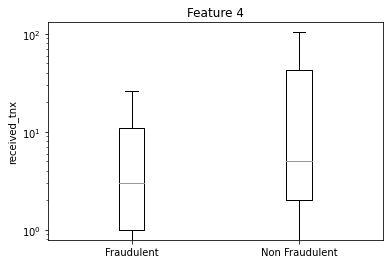

In [34]:
feature4 = pd.DataFrame(X_train['received_tnx'])
feature4_flag = pd.DataFrame(y_train)
feature_4_df = pd.concat([feature4, feature4_flag], axis = 1)

dataf41 = feature_4_df[feature_4_df['flag'] == 1]['received_tnx']
dataf40 = feature_4_df[feature_4_df['flag'] == 0]['received_tnx']

my_dict = {'Fraudulent': dataf41, 'Non Fraudulent': dataf40}

fig, ax = plt.subplots()
ax.boxplot(my_dict.values(),showfliers=False)

ax.set_xticklabels(my_dict.keys())
ax.set_ylabel("received_tnx")
plt.yscale("log")

ax.set_title("Feature 4")

### Distribution of Feature 5

Text(0.5, 1.0, 'Feature 5')

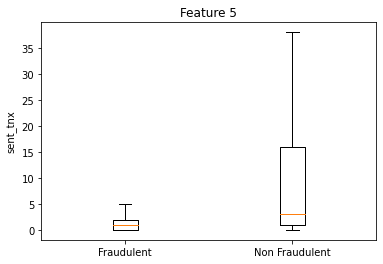

In [33]:
feature5 = pd.DataFrame(X_train['sent_tnx'])
feature5_flag = pd.DataFrame(y_train)
feature_5_df = pd.concat([feature5, feature5_flag], axis = 1)

dataf51 = feature_5_df[feature_5_df['flag'] == 1]['sent_tnx']
dataf50 = feature_5_df[feature_5_df['flag'] == 0]['sent_tnx']

my_dict = {'Fraudulent': dataf51, 'Non Fraudulent': dataf50}

fig, ax = plt.subplots()
ax.boxplot(my_dict.values(),showfliers=False)

ax.set_xticklabels(my_dict.keys())
ax.set_ylabel("sent_tnx")
#plt.yscale("log")

ax.set_title("Feature 5")